## Observations and Insights 

In [77]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "Resources/Mouse_metadata.csv"
study_results_path = "Resources/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset (Mouse ID)
comb_df = pd.merge(mouse_metadata, study_results, on='Mouse ID', how='outer')


# Display the data table for preview
comb_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [26]:
# Checking the number of mice. 
# comb_df.dtypes
len(comb_df["Mouse ID"].unique())

249

In [27]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
# There are 5 duplicates and they are only in the study_results data frame. 
dup_mt_df = pd.DataFrame(comb_df, columns = ["Mouse ID", "Timepoint"])

dup_mt_df = dup_mt_df[dup_mt_df.duplicated()]
dup_mt_df


,Mouse ID,Timepoint
909,g989,0
911,g989,5
913,g989,10
915,g989,15
917,g989,20


In [28]:
dup_study = pd.DataFrame(study_results, columns = ["Mouse ID", "Timepoint"])

dup_study = dup_study[dup_study.duplicated()]

dup_study

,Mouse ID,Timepoint
137,g989,0
360,g989,5
681,g989,10
869,g989,15
1111,g989,20


In [29]:
# Print these to find duplicates in each of the two main data frames
g989_meta = mouse_metadata.loc[mouse_metadata["Mouse ID"] == "g989", :]
g989_study = study_results.loc[study_results["Mouse ID"] == "g989", :]
g989_study

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
107,g989,0,45.000000,0
137,g989,0,45.000000,0
329,g989,5,48.786801,0
360,g989,5,47.570392,0
620,g989,10,51.745156,0
681,g989,10,49.880528,0
815,g989,15,51.325852,1
869,g989,15,53.442020,0
950,g989,20,55.326122,1
1111,g989,20,54.657650,1


In [30]:
# Optional: Get all the data for the duplicate mouse ID. 
g989_all = comb_df.loc[comb_df["Mouse ID"] =="g989", :]
g989_all

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [31]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
clean_df = comb_df.loc[comb_df["Mouse ID"] != "g989", :]
clean_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [32]:
# Checking the number of mice in the clean DataFrame. Since we took out the Mouse ID g989 there should be 248
clean_mouse_unique = len(clean_df['Mouse ID'].unique())
clean_mouse_unique


248

## Summary Statistics

In [33]:
# Creating a new df that organizes tumor size
clean_df_size = clean_df.sort_values(["Tumor Volume (mm3)"], ascending=True)

clean_df_size.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
9,k403,Ramicane,Male,21,16,45,22.050126,1
19,s185,Capomulin,Female,3,17,45,23.343598,1
8,k403,Ramicane,Male,21,16,40,24.365505,1
18,s185,Capomulin,Female,3,17,40,25.472143,1
7,k403,Ramicane,Male,21,16,35,26.546993,1


In [34]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method is the most straighforward, creating multiple series and putting them all together at the end.

drug_group = clean_df_size.groupby(["Drug Regimen"])
drug_group.head()

# Getting statistical info
tumor_mean = drug_group["Tumor Volume (mm3)"].mean()
tumor_median = drug_group["Tumor Volume (mm3)"].median()
tumor_variance = drug_group["Tumor Volume (mm3)"].var()
tumor_std = drug_group["Tumor Volume (mm3)"].std()
tumor_sem = drug_group["Tumor Volume (mm3)"].sem()

# Below are other methods of gathering statistical data 
# clean_df[["Drug Regimen", "Tumor Volume (mm3)"]].describe()
#clean_df.groupby("Drug Regimen").agg({"Tumor Volume (mm3)": ['mean', 'median', 'var', 'std','sem']})


In [35]:
# Creating a new df to hold are stat values
summary_stats = pd.DataFrame({"Mean": tumor_mean, "Median": tumor_median, "Variance": tumor_variance, 
                              "Standard Deviation": tumor_std, "SEM": tumor_sem})

summary_stats

,Mean,Median,Variance,Standard Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [36]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
#group data by drug and timepoint 
# This method produces everything in a single groupby function

clean_df.groupby("Drug Regimen").agg({"Timepoint": ['mean', 'median', 'var', 'std','sem']})


Timepoint                                        
                   mean median         var        std       sem
Drug Regimen                                                   
Capomulin     21.565217     20  206.928043  14.384994  0.948518
Ceftamin      19.747191     20  204.031772  14.283969  1.070629
Infubinol     18.174157     15  181.534470  13.473473  1.009879
Ketapril      19.707447     20  196.839089  14.029935  1.023238
Naftisol      19.623656     20  201.208951  14.184814  1.040081
Placebo       18.674033     15  192.954266  13.890798  1.032495
Propriva      17.060811     15  187.050699  13.676648  1.124214
Ramicane      21.425439     20  203.796178  14.275720  0.945433
Stelasyn      19.226519     20  191.620626  13.842710  1.028921
Zoniferol     19.368132     15  206.918979  14.384679  1.066263

## Bar and Pie Charts

In [67]:
# Creating new data frame for bar graph
regimen_pandas_bar = clean_df.groupby(["Drug Regimen"]).count()["Mouse ID"]

regimen_pandas_bar

#clean_df_size = clean_df.sort_values(["Tumor Volume (mm3)"], ascending=True)


Drug Regimen
Capomulin    230
Ceftamin     178
Infubinol    178
Ketapril     188
Naftisol     186
Placebo      181
Propriva     148
Ramicane     228
Stelasyn     181
Zoniferol    182
Name: Mouse ID, dtype: int64

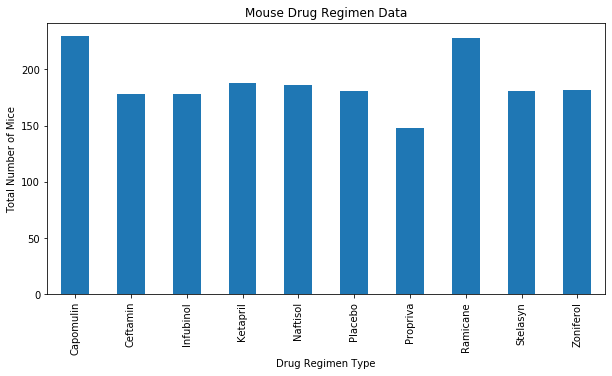

<Figure size 432x288 with 0 Axes>

In [50]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas.
regimen_pandas_bar.plot(kind="bar", figsize=(10,5))
#df.sort_values('c', ascending=False)[['a','b']].plot.bar(stacked=True)
# df_sorted= df.sort_values('Salary')

# Bar Titles
plt.title("Mouse Drug Regimen Data")
plt.xlabel("Drug Regimen Type")
plt.ylabel("Total Number of Mice")

#show chart and set layout
plt.show()
plt.tight_layout()

Text(0, 0.5, 'Total Number of Mice')

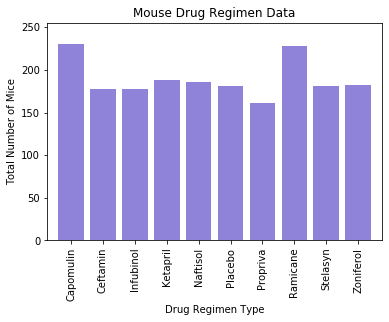

In [44]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

#Create an arraw with the datapoints
mouse = [230, 178, 178, 188, 186, 181, 161, 228, 181, 182]

#Set the x_axis to be the amount of the Data Regimen
x_axis = np.arange(len(regimen_pandas_bar))

plt.bar(x_axis, mouse, color='slateblue', alpha=0.75, align='center')

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ['Capomulin', 'Ceftamin', 'Infubinol', 'Ketapril', 'Naftisol', 'Placebo', 'Propriva', 'Ramicane', 'Stelasyn', 'Zoniferol'],  rotation='vertical')

plt.xlim(-0.75, len(x_axis)-0.25)

plt.ylim(0, max(mouse)+25)

plt.title("Mouse Drug Regimen Data")
plt.xlabel("Drug Regimen Type")
plt.ylabel("Total Number of Mice")

In [40]:
# Make new groupby data frame to get info on mouse ID & Sex
gender_df = clean_df.groupby(["Mouse ID","Sex"])
gender_df

mouse_gender_df = pd.DataFrame(gender_df.size())

# Make a new data frame with male/female count via groupby
mouse_gender = pd.DataFrame(mouse_gender_df.groupby(["Sex"]).count())
mouse_gender.columns = ["Total Count"]

# Making the number a percentage
mouse_gender["Percentage of Sex"] = (100*(mouse_gender["Total Count"]/mouse_gender["Total Count"].sum()))

# Formating & printing
mouse_gender["Percentage of Sex"] = mouse_gender["Percentage of Sex"]

mouse_gender


,Total Count,Percentage of Sex
Sex,,
Female,123,49.596774
Male,125,50.403226


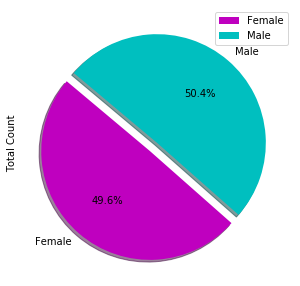

In [42]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

colors = ['m', 'c']

explode = (0.1, 0)

# Execute correct formating to print pie chart 
plot = mouse_gender.plot.pie(y='Total Count',figsize=(5,5), 
                             colors = colors, startangle=140, 
                             explode = explode, 
                             shadow = True, autopct="%1.1f%%")


(-1.1877230750926049,
 1.111197451260921,
 -1.1963304488776791,
 1.1123702248046798)

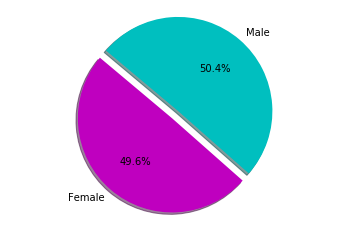

In [18]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

# Setting up are variables
gender_sizes = [49.596774, 50.403226]
gender_labels = ["Female", "Male"]
color = ['M',"C"]
explode = (0.1, 0)

# Setting up & printing pie chart
plt.pie(gender_sizes, explode=explode, labels=gender_labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)

plt.axis("equal")




## Quartiles, Outliers and Boxplots

In [24]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Making new df
top_four = clean_df[clean_df["Drug Regimen"].isin(["Capomulin", "Ramicane", "Infubinol", "Ceftamin"])]

top_four = top_four.sort_values(["Timepoint"], ascending=True)

top_four


# Start by getting the last (greatest) timepoint for each mouse
top_four_last = top_four.groupby(['Drug Regimen', 'Mouse ID']).last()['Tumor Volume (mm3)']
top_four_last.head()


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


Drug Regimen  Mouse ID
Capomulin     b128        38.982878
              b742        38.939633
              f966        30.485985
              g288        37.074024
              g316        40.159220
Name: Tumor Volume (mm3), dtype: float64

In [20]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [21]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

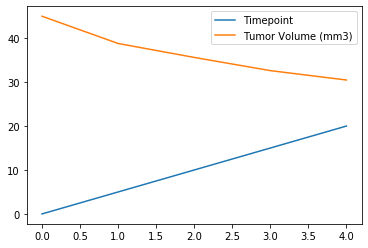

In [22]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin (f966)
time_vs_tumor = clean_df[clean_df["Mouse ID"].isin(["f966"])]

# Creating df with specfic columns
time_vs_tumor_info = time_vs_tumor[["Mouse ID", "Timepoint", "Tumor Volume (mm3)"]]
time_vs_tumor_info

# Reseting index
line_plot_df = time_vs_tumor_info.reset_index()

# Creating final line plot of mouse ID 'f966'
line_plot_f966 = line_plot_df[["Mouse ID", "Timepoint", "Tumor Volume (mm3)"]]
line_plot_f966

lines = line_plot_f966.plot.line()



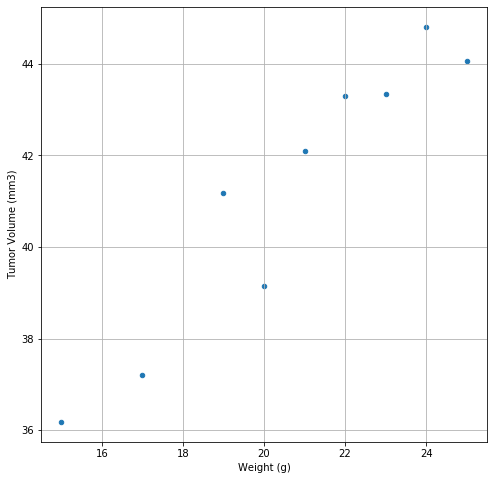

In [79]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
capomulin_scatter = clean_df[clean_df["Drug Regimen"].isin(["Capomulin"])]

capomulin_scatter_df = top_four[["Mouse ID","Weight (g)", "Tumor Volume (mm3)"]]

capomulin_sorted = capomulin_scatter_df.sort_values(["Weight (g)"], ascending=True)

capomulin_scatter_plot = capomulin_scatter.reset_index()

capomulin_groupby_weight = capomulin_scatter_plot.groupby("Weight (g)")["Tumor Volume (mm3)"].mean()

capo_groupby_plot = pd.DataFrame(capomulin_grouped_weight).reset_index()


#capomulin_scatter = capomulin_grouped_weight.plot.scatter(x='Weight (g)', y='Tumor Volume (mm3)')
#
capomulin_scatter = capo_groupby_plot.plot(kind='scatter', x='Weight (g)', y='Tumor Volume (mm3)', grid = True, figsize= (8,8))

## Correlation and Regression

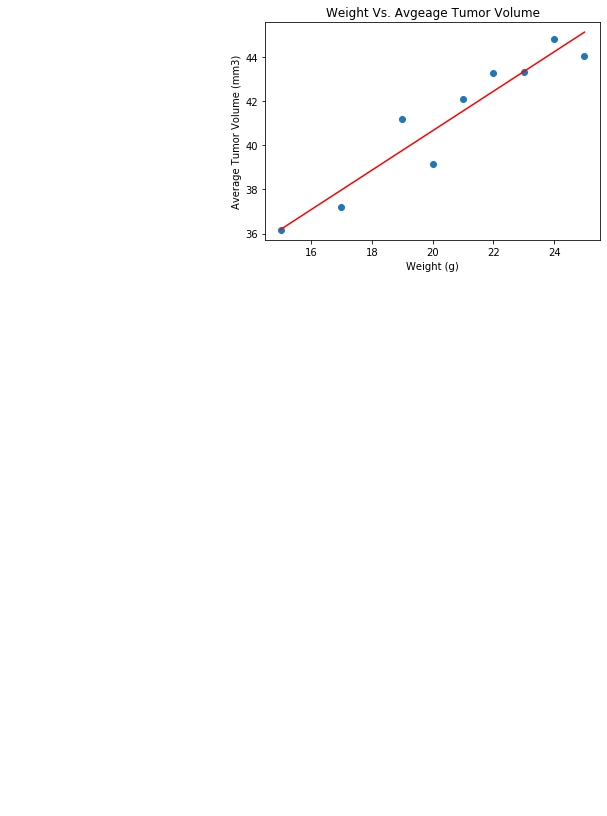

In [83]:
# Calculate the correlation coefficient and linear regression model 


# for mouse weight and average tumor volume for the Capomulin regimen
x_values = capo_groupby_plot["Weight (g)"]
y_values = capo_groupby_plot["Tumor Volume (mm3)"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y =" + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=10,color="red")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.title("Weight Vs. Avgeage Tumor Volume")
plt.show()